# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Содержание

1. [Шаг 1. Изучение общей информации](#Шаг1)
2. [Шаг 2. Предобработка данных](#Шаг2)
3. [Шаг 3. Дополнительные расчеты](#Шаг3)
4. [Шаг 4. Проведение исследовательского анализа данных](#Шаг4)
 1. [4.1 Изучение следующих параметров: площадь, цена, число комнат, высота потолков. Построение гистограммы для каждого параметра.](#Шаг41)
 2. [4.2 Изучение времени продажи квартиры. Построение гистограммы. Расчет среднего и медианы.](#Шаг42)
 3. [4.3 Уберем редкие и выбивающиеся значения.](#Шаг43)
 4. [4.4 Определение факторов, которые больше всего влияют на стоимость квартиры.](#Шаг44)
 5. [4.5 Выберем 10 населённых пунктов с наибольшим числом объявлений.](#Шаг45)
 6. [4.6 Изучим предложения квартир в Санкт-Петербурге.](#Шаг46)
 7. [4.7 Выделим сегмент квартир в центре для отдельного анализа.](#Шаг47)
5. [Шаг 5. Общий вывод](#Шаг5)

 ###  Шаг 1. Изучение общей информации <a name="Шаг1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

real_estate_data = pd.read_csv('real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
real_estate_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт-Петербург           18863.0   
1      False          11.0      2.0   посёлок Шушары           12817.0   
2      False           8.3      0.0  Санкт-Петербург           21741.0   
3      False           NaN      0.0  Санкт-Петербург           28098.0   
4      False          41.0      NaN  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0

In [2]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

### Вывод

При первичном изучении датасета можно сказать, что у нас довольно много информации по разным критериям, но не все данные представлены в полном объеме. Пропуски имеются как в данных, полученных непосредственно от пользователей, так и в данных, полученных автоматически на основе картографических данных.

Пропуски в данных, полученных от пользователей, говорят, что скорее всего человек не заполнил все поля формы и что-то решил оставить незаполненным. Так может произойти, потому что пользователь не знает точных значений (колонки с высотой потолков или с площадью комнат в квартире), либо специально оставляет поле незаполненным, если вопрос подразумевает наличие (отсутствие) чего-либо (такие колонки, как наличие балкона или является ли квартира апартаментами).

В автоматически полученных данных пропуски появляются из-за настроек сбора. Программа ставит пропуск при отсутствии чего-либо из критериев, например, нет парка в радиусе 3 км - пропуск, нет аэропорта в населенном пункте - пропуск.

Названия колонок хорошо отражают представленную информацию, но с пропусками и типами данных нужно будет поработать.

### Шаг 2. Предобработка данных <a name="Шаг2"></a>

Начнем заполнение пропущенных значений с колонки **is_apartment**. Пропуски в этой колонке вероятнее всего появились потому, что пользователи не стали заполнять эту графу и пропустили ее, так как их квартира апартаментами не является. Поэтому все пропуски здесь заменим на **False**.

In [3]:
real_estate_data['is_apartment'].fillna(False, inplace=True)
real_estate_data['is_apartment'].unique()

array([False,  True])

Пропуски в колонке **balcony** могли появиться по той же самой причине: пропуск значит отсутствие балкона, значит можем заменить на 0.

Сразу заменим тип данных в этой колонке с вещественного на целочисленный, так как дробных значений в количестве балконов быть не может.

In [4]:
real_estate_data['balcony'].fillna(0, inplace=True)
real_estate_data['balcony'] = real_estate_data['balcony'].astype(int)
real_estate_data['balcony'].unique()

array([0, 2, 1, 5, 4, 3])

В колонках **parks_around3000** и **ponds_around3000** также заменим пропуски на 0, так как колонки содержат информацию о количестве парков и водоемов и пропуски вероятнее всего означают отсутствие таковых в указанном радиусе.

In [5]:
real_estate_data['parks_around3000'].fillna(0, inplace=True)
real_estate_data['parks_around3000'] = real_estate_data['parks_around3000'].astype(int)

real_estate_data['ponds_around3000'].fillna(0, inplace=True)
real_estate_data['ponds_around3000'] = real_estate_data['ponds_around3000'].astype(int)

print(real_estate_data['parks_around3000'].unique())
print(real_estate_data['ponds_around3000'].unique())

[1 0 2 3]
[2 0 3 1]


Данные в колонке **first_day_exposition** приведем в формат даты, время включать не будем, оно не информативно и в данном случае оно нам не нужно.

In [6]:
real_estate_data['first_day_exposition'] = pd.to_datetime(real_estate_data['first_day_exposition'], format='%Y-%m-%d')
real_estate_data['first_day_exposition'].head()

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

Пропуски в колонке **floors_total** заполним медианой в зависимости от локации. При этом, если медиана окажется меньше, чем этаж квартиры, то пропуск заполняется на значение этажа. Пропуски в этой колонке могли появится, если пользователи посчитали ненужным вписывать в форму данную информацию, либо проживают на последнем этаже и решили, что не стоит дублировать.

In [7]:
def floors(df, floors_total, floor, locality_name):
    for locality in df[locality_name].unique():
        median_floor = df.loc[df[locality_name] == locality, floors_total].median()
        df.loc[(df[floors_total].isna()) & (df[floor] >= median_floor) & (df[locality_name] == locality), floors_total] = df[floor]
    return df

def floors_less(df, floors_total, floor, locality_name):
    for locality in df[locality_name].unique():
        median_floor = df.loc[df[locality_name] == locality, floors_total].median()
        df.loc[(df[floors_total].isna()) & (df[floor] < median_floor) & (df[locality_name] == locality), floors_total] = median_floor
    return df

real_estate_data = floors(real_estate_data, 'floors_total', 'floor', 'locality_name')
real_estate_data = floors_less(real_estate_data, 'floors_total', 'floor', 'locality_name')

Пропуски в колонке **ceiling_height** заполним медианами в зависимости от этажности дома: первая категория до 9 этажей включительно, вторая категория - выше 9 этажей. 9-й этаж был выбран в качестве границы в связи с тем, что дома до 9 этажей в большинстве случаев принадлежат старому фонду с более высокими потолками. Современные зачастую строят выше и такие дома имеют менее высокие потолки.

In [8]:
median_upto9 = real_estate_data.loc[real_estate_data['floors_total'] <= 9, 'ceiling_height'].median()
median_above9 = real_estate_data.loc[real_estate_data['floors_total'] > 9, 'ceiling_height'].median()

def ceil_upto9(df, ceiling_height, floors_total):
    for floors in df[floors_total].unique():
        df.loc[(df[ceiling_height].isna()) & (df[floors_total] <= 9), ceiling_height] = median_upto9
    return df

def ceil_above9(df, ceiling_height, floors_total):
    for floors in df[floors_total].unique():
        df.loc[(df[ceiling_height].isna()) & (df[floors_total] > 9), ceiling_height] = median_above9
    return df

real_estate_data = ceil_upto9(real_estate_data, 'ceiling_height', 'floors_total')
real_estate_data = ceil_above9(real_estate_data, 'ceiling_height', 'floors_total')

Пропуски в данных по площади **living_area** и **kitchen_area** заполним по медиане в зависимости от количества комнат в квартире. Конечно, есть и нестандартные планировки с большими кухнями, кухни-гостинные и просто очень большие комнаты (когда самих комнат не много), поэтому медиана поможет избежать сильных искажений на фоне таких случаев. В большинстве квартир все-таки более-менее стандартные планировки. 

In [9]:
room = real_estate_data['rooms'].unique()

for rooms in room:
    median_living = real_estate_data.loc[real_estate_data['rooms'] == rooms, 'living_area'].median()
    real_estate_data.loc[(real_estate_data['living_area'].isna()) & (real_estate_data['rooms'] == rooms), 'living_area'] = median_living

for rooms in room:
    median_kitchen = real_estate_data.loc[real_estate_data['rooms'] == rooms, 'kitchen_area'].median()
    real_estate_data.loc[(real_estate_data['kitchen_area'].isna()) & (real_estate_data['rooms'] == rooms), 'kitchen_area'] = median_kitchen

После заполнения пропусков в этих колонках, проверка через info показала, что в колонке **kitchen_area** заполнились не все пропуски. Проверка через конструкцию ниже показала, что пропуски остались только там, где количество комнат = 0, что логично, так как одно общее пространство в этом случае занимает жилая зона. Оставим эти пропуски так, как есть и не будем заполнять их нулями, чтобы потом мы смогли корректно оценивать площадь кухонь только в тех случаях, где они есть.

In [10]:
real_estate_data.loc[real_estate_data['kitchen_area'].isna(), 'rooms'].unique()

array([0], dtype=int64)

У нас есть колонки, в которых данные отражают расстояние до ближайшего объекта, соответствующего названию колонки: **airports_nearest**, **cityCenters_nearest**, **parks_nearest** и **ponds_nearest**. Отсутствие значений в этих колонках скорее всего показывает, что поблизости нет таких объектов. Если заменять пропуски пустой строкой, то далее мы не сможем выполнять математические операции с данными в этих колонках, поэтому просто оставляем пропуски.

Проверим наличие дубликатов в датасете. Если их нет, то ничего пока удалять не нужно.

In [11]:
duplicates_amount = real_estate_data.duplicated().sum() / len(real_estate_data)
print('Процент дублирующихся строк: {:.2%}'.format(duplicates_amount))

Процент дублирующихся строк: 0.00%


Посмотрим что в итоге получилось:

In [12]:
real_estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23698 non-null  float64       
 6   floors_total          23698 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23502 non-null  float64       
 13  balcony         

### Вывод

В данных имелись пропуски как в части, куда информацию вносил пользователь, так и в части, где информация собиралась автоматически. В данных с обоих источников были пропуски, которые можно было заполнить на основе логических предположений (типа "да/нет", количественные с малым набором уникальных значений), но также и пропуски, заполнение которых могло бы наоборот усложнить дальнейший анализ или исказить данные, поэтому такие пропуски были оставлены незаполненными.

### Шаг 3. Дополнительные расчеты <a name="Шаг3"></a>

Добавим в таблицу несколько дополнительных столбцов, чтобы по ним можно было провести анализ. Начнем с цены за квадратный метр.

In [13]:
real_estate_data['price_per_meter'] = real_estate_data['last_price'] / real_estate_data['total_area']

Далее добавим день недели, месяц и год публикации объявления.

In [14]:
real_estate_data['weekday'] = real_estate_data['first_day_exposition'].dt.weekday
real_estate_data['month'] = real_estate_data['first_day_exposition'].dt.month
real_estate_data['year'] = real_estate_data['first_day_exposition'].dt.year

Добавим столбец, описывающий этаж квартиры, как "первый", "последний" или "другой".

In [15]:
def floor_type(df):
    floor = df['floor']
    floors_total = df['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'

real_estate_data['floor_type'] = real_estate_data.apply(floor_type, axis=1)

Добавим еще два столбца с соотношением жилой и общей площади, а также с отношением площади кухни к общей.

In [16]:
real_estate_data['living_to_total_area'] = real_estate_data['living_area'] / real_estate_data['total_area']
real_estate_data['kitchen_to_total_area'] = real_estate_data['kitchen_area'] / real_estate_data['total_area']

Посмотрим как теперь выглядит датафрейм.

In [17]:
real_estate_data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0           2019-03-07      3   
1             7   3350000.0        40.4           2018-12-04      1   
2            10   5196000.0        56.0           2015-08-20      2   
3             0  64900000.0       159.0           2015-07-24      3   
4             2  10000000.0       100.0           2018-06-19      2   

   ceiling_height  floors_total  living_area  floor  is_apartment  studio  \
0            2.70          16.0         51.0      8         False   False   
1            2.70          11.0         18.6      1         False   False   
2            2.60           5.0         34.3      4         False   False   
3            2.70          14.0         45.0      9         False   False   
4            3.03          14.0         32.0     13         False   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0        0  Санкт-Петербург           18863.0   
1      False          11.0        2   посёлок Шушары           12817.0   
2      False           8.3        0  Санкт-Петербург           21741.0   
3      False           9.5        0  Санкт-Петербург           28098.0   
4      False          41.0        0  Санкт-Петербург           31856.0   

   cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0                 1          482.0                 2   
1              18603.0                 0            NaN                 0   
2              13933.0                 1           90.0                 2   
3               6800.0                 2           84.0                 3   
4               8098.0                 2          112.0                 1   

   ponds_nearest  days_exposition  price_per_meter  weekday  month  year  \
0          755.0              NaN    120370.370370        3      3  2019   
1            NaN             81.0     82920.792079        1     12  2018   
2          574.0            558.0     92785.714286        3      8  2015   
3          234.0            424.0    408176.100629        4      7  2015   
4           48.0            121.0    100000.000000        1      6  2018   

  floor_type  living_to_total_area  kitchen_to_total_area  
0     другой              0.472222               0.231481  
1     первый              0.460396               0.272277  
2     другой              0.612500               0.148214  
3     другой              0.283019               0.059748  
4     другой              0.320000               0.410000

### Вывод

Добавили несколько столбцов с дополнительными данными, которые помогут нам более полно ценить информацию:
* цена за квадратный метр
* день недели, месяц и год публикации объявления
* этаж квартиры с описанием: "первый", "последний" или "другой"
* соотношение жилой и общей площади
* соотношение площади кухни к общей

### Шаг 4. Проведение исследовательского анализа данных <a name="Шаг4"></a>

### 4.1 Изучение следующих параметров: площадь, цена, число комнат, высота потолков. Построение гистограммы для каждого параметра. <a name="Шаг41"></a>

Начнем изучение данных с общей площади квартир. Отбросим длинный хвостик с редко встречающимися значениями (более 200 квадратных метров), разложим значения на 20 корзин.

Распределение выглядит похожим на нормальное распределение с пиками в районе от 30 до 50 квадратных метров. Это говорит нам, что квартиры с таким метражом - самые популярные, что похоже на правду. Далее спад по увеличению метража идет довольно равномерно.

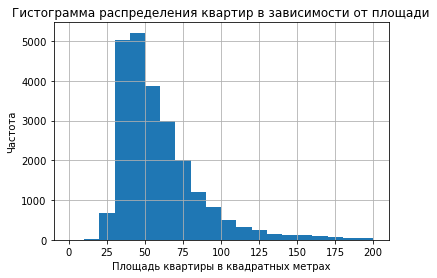

In [18]:
real_estate_data['total_area'].hist(bins=20, range=(0, 200))
plt.title('Гистограмма распределения квартир в зависимости от площади')
plt.xlabel('Площадь квартиры в квадратных метрах')
plt.ylabel('Частота')
plt.show()

Для изучения цен на квартиры уберем длинный хвостик с ценой более 30 млн, в противном случае график сложно читаем. На графике видны пики на уровне цен от 3 до 5 млн, что выглядит правдоподобно, вспоминая какие самые популярные площади у квартир.

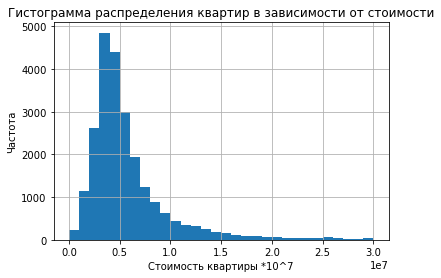

In [19]:
real_estate_data['last_price'].hist(bins=30, range=(0, 30000000))
plt.title('Гистограмма распределения квартир в зависимости от стоимости')
plt.xlabel('Стоимость квартиры *10^7')
plt.ylabel('Частота')
plt.show()

Для просмотра гистограммы по числу комнат, установим число корзин равное количеству уникальных значений в этой колонке. Видно, что наиболее популярные варианты - это однушки и двушки. Трешки уже менее популярны, а дальнейшее увеличение количества комнат совсем становится редким.

In [20]:
real_estate_data['rooms'].hist(bins=17)
plt.title('Гистограмма распределения квартир в зависимости от числа комнат')
plt.xlabel('Число комнат')
plt.ylabel('Частота')
plt.show()

В высоте потолков явные лидеры со значениями от 2,5 до 2,8 метров, есть пара маленьких пиков на 2,9 и 3,1. Также встречаются более редкие и уникальные варианты с высотой вплоть до 4,5 метров.

In [21]:
real_estate_data['ceiling_height'].hist(bins=25, range=(2, 4.5))
plt.title('Гистограмма распределения квартир в зависимости от высоты потолков')
plt.xlabel('Высота потолков в м')
plt.ylabel('Частота')
plt.show()

### 4.2 Изучение времени продажи квартиры. Построение гистограммы. Расчет среднего и медианы. <a name="Шаг42"></a>

Для изучения времени продажи квартиры построим гистрограммы с помощью библиотеки plotly, она более интерактивная. Вначале выведем на гистрограмму все имеющиеся данные, затем уберем хвостик, чтобы более детально изучить основное скопление.

In [22]:
fig = px.histogram(real_estate_data, x='days_exposition', marginal='box')
fig.update_layout(title='Гистограмма распределения квартир в зависимости от срока размещения объявления', xaxis_title='Сколько дней было размещено объявление', yaxis_title='Частота')
fig.show()

In [23]:
fig = px.histogram(real_estate_data, x='days_exposition', nbins=600, range_x=[0, 300])
fig.update_layout(title='Гистограмма распределения квартир в зависимости от срока размещения объявления', xaxis_title='Сколько дней было размещено объявление', yaxis_title='Частота')
fig.show()

In [24]:
real_estate_data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Первый пик удачных сделок происходит в течение первой недели, после выставления объявления о продаже квартиры. Однако, наибольшая частота приходится на период, равный полутора месяцам с начала старта продаж. Видимо, именно столько времени в большинстве случаев требуется людям, чтобы просмотреть все подходящие варианты, оценить их и определиться с выбором приобретаемого жилья. Следующий заметный пик происходит спустя 2 месяца, после публикации объявления, далее еще один на 3 месяцах. За 3-месячный срок закрывается половина всех сделок по купле-продаже жилья. Далее идет равномерный спад и данные вытягиваются в очень длинный хвостик.

Среднее время продажи больше медианного в 2 раза, что еще раз говорит нам, что в данных есть ряд очень высоких значений. Также это подтверждается тем, что максимум среди 75% данных - 232 дня, а общий максимум - 1580 дней. Это почти в 7 раз больше. Тем не менее, можно считать, что необычно долгие продажи превышают верхнюю границу ("правый ус") диаграммы размаха, что будет больше 512 дней. Вероятно, в эту категорию попадает не самое ликвидное жилье: квартиры премиум-класса с большой площадью и большим количеством комнат. Также вероятно, что сюда попадают и квартиры, находящиеся в отдаленых от города поселках и деревнях, куда не так много людей стремится переехать.

В связи с тем, что уже на 3-7 дней после публикации объявления мы видим первый пик, то можно сказать, что необычно быстрая продажа будет считаться в первые 1-2 дня после начала.

### 4.3 Уберем редкие и выбивающиеся значения. <a name="Шаг43"></a>

Самый главный показатель, который мы изучаем - это стоимость квартиры. Можно убрать редкие и выбивающиеся значения именно с данных по этому показателю, тогда соответственно, мы также автоматически исключим большинство редких и выбивающихся значений из других показателей (например площадь и число комнат), которые по логике напрямую зависят от цены.

Выведем диаграмму размаха для значений цены. Границу будущего среза определим не по верхней границе ("правый ус") диаграммы размаха, иначе срежутся слишком много данных. Границей станет цена, после которой гистограмма визуально переходит в горизонтальную тонкую линию, что как раз говорит о редкости квартир с такой высокой ценой.

Сохраним срез в новой переменной **sample** для дальнейшей работы.

In [25]:
fig = px.histogram(real_estate_data, x='last_price', marginal='box', range_x=[0, 20000000])
fig.update_layout(title='Гистограмма распределения квартир в зависимости от стоимости', xaxis_title='Стоимость квартиры', yaxis_title='Частота')
fig.show()

In [26]:
sample = real_estate_data.query('last_price < 20000000')

### 4.4 Определение факторов, которые больше всего влияют на стоимость квартиры. Изучение зависимости цены от площади, числа комнат, удалённости от центра. Изучение зависимости цены от того, на каком этаже расположена квартира: первом, последнем или другом. Изучение зависимости от даты размещения: дня недели, месяца и года. <a name="Шаг44"></a>

Построим матрицу диаграмм рассеяния, чтобы посмотреть на зависимости цены, площади, числа комнат и удаленности от центра.

                     last_price  total_area     rooms  cityCenters_nearest
last_price             1.000000    0.772653  0.512926            -0.355309
total_area             0.772653    1.000000  0.798242            -0.196710
rooms                  0.512926    0.798242  1.000000            -0.142166
cityCenters_nearest   -0.355309   -0.196710 -0.142166             1.000000


array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='total_area', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='total_area'>,
        <AxesSubplot:xlabel='total_area', ylabel='total_area'>,
        <AxesSubplot:xlabel='rooms', ylabel='total_area'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='total_area'>],
       [<AxesSubplot:xlabel='last_price', ylabel='rooms'>,
        <AxesSubplot:xlabel='total_area', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>],
       [<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='total_area', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='rooms', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xl

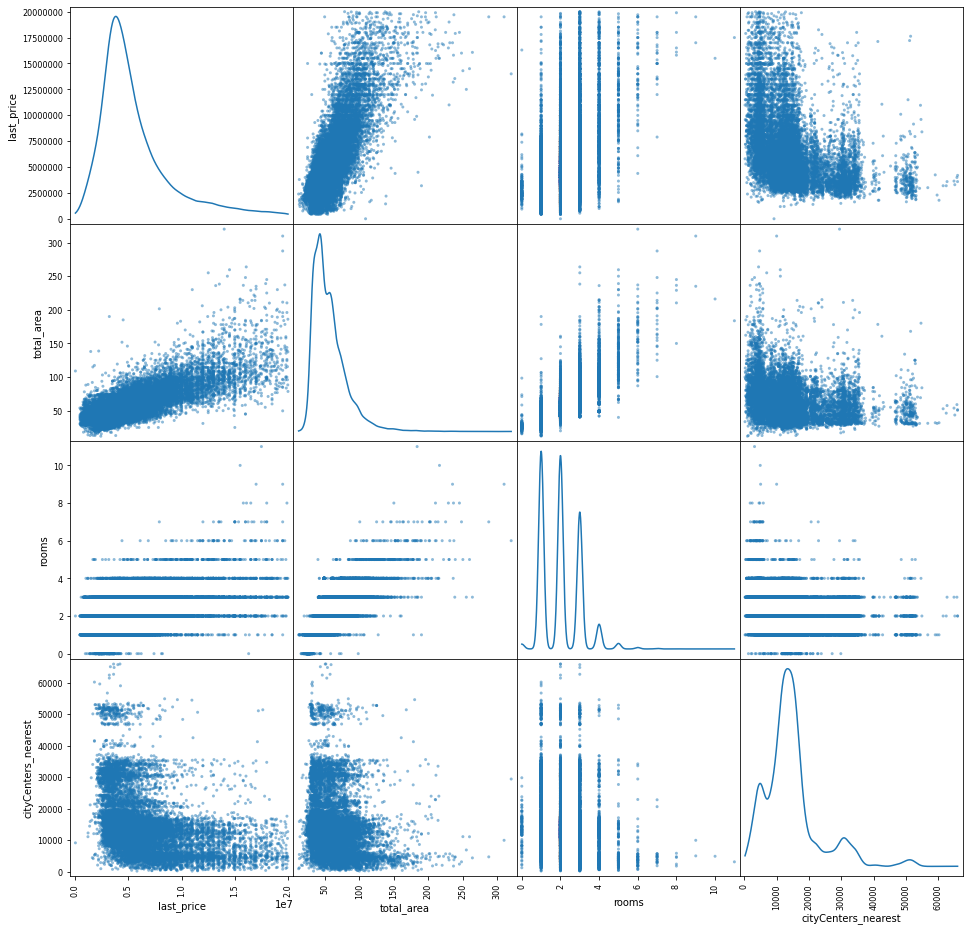

In [27]:
sample_cols_area = ['last_price', 'total_area', 'rooms', 'cityCenters_nearest']
print(sample[sample_cols_area].corr())
pd.plotting.scatter_matrix(sample[sample_cols_area], diagonal='kde', figsize=(16, 16))

Зависимость цены от площади в основном почти линейная, коэффициент корреляции Пирсона 0.77 также это подтверждает. Конечно есть и выбивающиеся значения.

Распределение по числу комнат четко распределено по сегментам в зависимости от количества комнат. Видно, что есть тренд на увеличение цены с ростом числа комнат, но это не линейно и наблюдается от 5-6 комнат. Хорошо видно, что студии и однушки в основном более дешевые, а вот 2-3-4-комнатные квартиры можно найти в широком ценовом диапазоне. 5-комнатные квартиры в основном в среднем ценовом сегменте, с дальнейшим увеличением комнат идет подорожание.

Коэффициент корреляции Пирсона -0.35 говорит, что какая-то зависимость цены от удаленности от центра все таки есть - чем дальше от центра, тем дешевле. Диаграмма рассеяния показывает, что в радиусе 20 км находится наибольшее число объявлений в самом широком ценовом диапазоне. Далее идет более дешевый сегмент в радиусе от 20 до 40 км с малым количеством выбросов дорогих квартир. Примерно в радиусе 50 км находится еще одно скопление недорогих квартир, также с уникальными единичными выбросами дорогих.

Посмотрим, влияет ли этаж на стоимость квартиры.

In [28]:
sample.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(grid=True, figsize=(9, 10))
plt.title('График зависимости медианной стоимости от типа этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Квартиры, расположенные на первых этажах явно проигрывают остальным, поэтому приходится подкупать снижением стоимости. На последних этажах также не все готовы охотно покупать, но цена все-таки повыше, чем у квартир на первых. Другие этажи пользуются большей популярностью - это обусловленно общим мнением о безопасности: на первый этаж злоумышленникам легче проникнуть снаружи, а на последнем этаже есть вероятность протечки крыши.

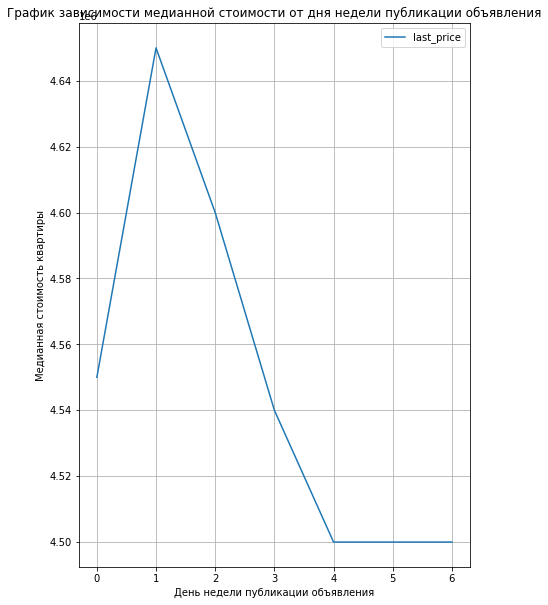

In [29]:
sample.pivot_table(index='weekday', values='last_price', aggfunc='median').plot(grid=True, figsize=(7, 10))
plt.title('График зависимости медианной стоимости от дня недели публикации объявления')
plt.xlabel('День недели публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Виден четкий пик, говорящий, что по вторникам люди склонны публиковать объявления по более высокой стоимости и к пятнице и выходным происходит спад. Может быть, люди чувствуют себя более расслабленно и более спокойно к выходным и публикуют более низкую цену.

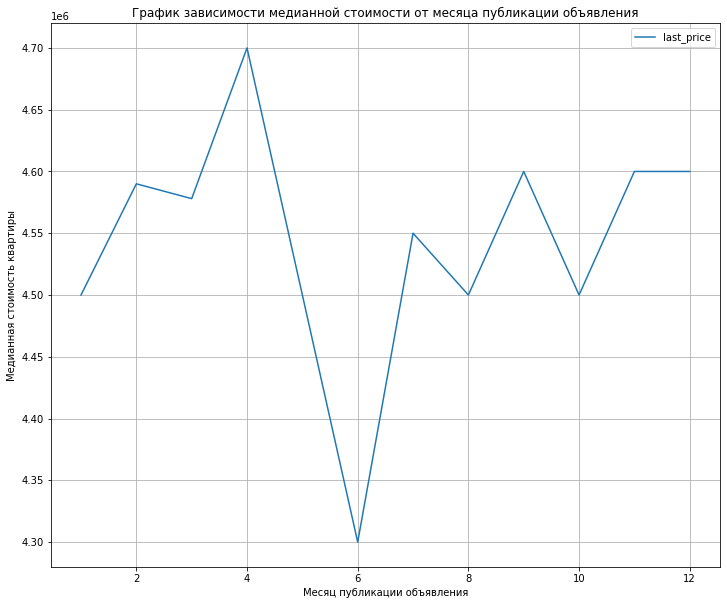

In [30]:
sample.pivot_table(index='month', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 10))
plt.title('График зависимости медианной стоимости от месяца публикации объявления')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Очень хорошо виден рост цен на квартиры с начала года и до весны такой тренд сохраняется. Затем, летом происходит спад, который снова начинает расти к зиме. В этом случае цена на квартиры скорее зависит от сезонного спроса, летом чаще всего недвижимость дешевеет, так как люди занимаются отдыхом и прочими делами.

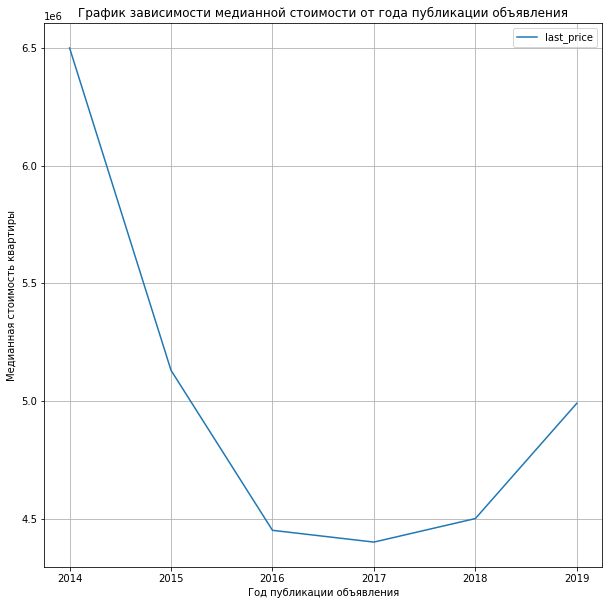

In [31]:
sample.pivot_table(index='year', values='last_price', aggfunc='median').plot(grid=True, figsize=(10, 10))
plt.title('График зависимости медианной стоимости от года публикации объявления')
plt.xlabel('Год публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Распределение цен по годам показывает нам спад после 2014-2015 годов, скорее всего это связано с финансовым кризисом в России в те годы. В кризис люди не склонны к необоснованным тратам и в целом неохотно идут на большие перемены в жизни, поэтому спад цен был обусловлен пониженным спросом. Далее после 2017 года идет восстановление и цены снова начинают расти.

### 4.5 Выберем 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах. Выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья. <a name="Шаг45"></a>

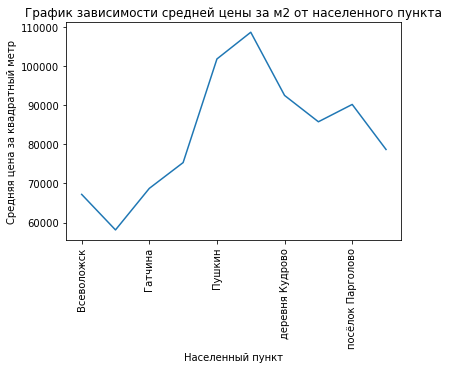

In [32]:
sample_count = sample.groupby('locality_name').count().sort_values(by='last_price', ascending=False).head(10)
sample.query('locality_name in @sample_count.index').groupby('locality_name')['price_per_meter'].mean().plot()
plt.title('График зависимости средней цены за м2 от населенного пункта')
plt.xticks(rotation=90)
plt.xlabel('Населенный пункт')
plt.ylabel('Средняя цена за квадратный метр')
plt.show()

На графике представлены 10 самых популярных населенных пунктов по числу опубликованных объявлений. Бесспорно, самое большое число объявлений было опубликовано по Санкт-Петербургу, там же и самая высокая цена за квадратный метр - около 110000р. Самая низкая стоимость квадратного метра среди данной выборки - в Выборге. Средняя цена там установилась на отметке в 60000р за квадратный метр.

### 4.6 Изучим предложения квартир в Санкт-Петербурге. Выясним, какая область входит в центр и как цена зависит от удалённости от центра. <a name="Шаг46"></a>

Выделим данные по Санкт-Петербургу в отдельный датафрейм и удалим строки с пропусками в колонке **cityCenters_nearest**. После этого создадим столбец с расстоянием до центра в километрах, округлим до целых и посчитаем среднюю цену для каждого километра. Посмотрим результат на графике.

In [33]:
saint_p = sample.query('locality_name == "Санкт-Петербург"')
saint_p.dropna(subset = ['cityCenters_nearest'], inplace=True)

In [34]:
saint_p['cityCenters_km'] = saint_p['cityCenters_nearest'] / 1000
saint_p['cityCenters_km'] = saint_p['cityCenters_km'].astype(int)
saint_p.pivot_table(index='cityCenters_km', values='last_price').plot(grid=True, figsize=(10, 10))
plt.title('График зависимости средней стоимости от расстояния от центра')
plt.xlabel('Расстояние от центра в км')
plt.ylabel('Средняя стоимость квартиры')
plt.show()

В зависимости от удаленности от центра в целом наблюдается снижение стоимости жилья, но видны два пика на 20 км и на 27-28 км. Вероятно, на этом расстоянии находятся современные более комфортабельные новостройки повышенного класса.

Из пиков близко к центру можно выделить пик на 4 км - его примем за границу области центра города, так как далее наблюдается довольно резкое падение цены.

### 4.7 Выделим сегмент квартир в центре для отдельного анализа. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). <a name="Шаг47"></a>

In [35]:
sample_saint_p = saint_p.query('cityCenters_km <= 4')
fig = px.histogram(sample_saint_p, x='total_area', color='rooms', marginal='box')
fig.update_layout(title='Гистограмма распределения квартир в зависимости от площади и числа комнат', xaxis_title='Площадь квартиры в квадратных метрах', yaxis_title='Частота')
fig.show()

In [36]:
fig = px.histogram(sample_saint_p, x='last_price', color='rooms', marginal='box')
fig.update_layout(title='Гистограмма распределения квартир в зависимости от стоимости и числа комнат', xaxis_title='Стоимость квартиры', yaxis_title='Частота')
fig.show()

In [37]:
fig = px.histogram(sample_saint_p, x='ceiling_height', color='rooms', marginal='box', range_x=[2, 5])
fig.update_layout(title='Гистограмма распределения квартир в зависимости от высоты потолков и числа комнат', xaxis_title='Высота потолков в м', yaxis_title='Частота')
fig.show()

Самые популярные квартиры в центре - квартиры с площадью от 60 до 75 квадратных метров, что соответствует популярности 1-, 3-комнатным квартирам и квартирам с 0 комнат, что принимаем за студию/открытую планировку. Также есть пик с 6-комнатными квартирами площадью под 100 квадратных метров - старый фонд Санкт-Петербурга, возможно раньше там были коммуналки.

Очень интересен график со стоимостью, он показывает большой разброс цен. То есть в центре можно найти как 4-х комнатную квартиру за малые деньги, так и дорогие 1-комнатные. В этом случае цена скорее всего больше зависит от года постройки и состояния дома. Также видно, что все таки самые популярные - однушки и трешки, которые можно найти со стоимостью в пределах 7 млн. По общим данным мы делали выводы о популярности однушек и двушек, и самая попурная цена была в диапазоне 3-5 млн, то есть в центре дороже.

Абсолютный лидер по высоте потолков - квартиры с потолками в районе 2,5-2,6 м. Также есть три небольших пика в диапазоне высоты от 3 до 3,5 м - скорее всего это фонд "сталинок".

In [38]:
sample_saint_p_col = ['last_price', 'rooms', 'cityCenters_nearest']
print(sample_saint_p[sample_saint_p_col].corr())
pd.plotting.scatter_matrix(sample_saint_p[sample_saint_p_col], diagonal='kde', figsize=(9, 9))

                     last_price     rooms  cityCenters_nearest
last_price             1.000000  0.500822            -0.042390
rooms                  0.500822  1.000000            -0.065006
cityCenters_nearest   -0.042390 -0.065006             1.000000


array([[<AxesSubplot:xlabel='last_price', ylabel='last_price'>,
        <AxesSubplot:xlabel='rooms', ylabel='last_price'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='last_price'>],
       [<AxesSubplot:xlabel='last_price', ylabel='rooms'>,
        <AxesSubplot:xlabel='rooms', ylabel='rooms'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='rooms'>],
       [<AxesSubplot:xlabel='last_price', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='rooms', ylabel='cityCenters_nearest'>,
        <AxesSubplot:xlabel='cityCenters_nearest', ylabel='cityCenters_nearest'>]],
      dtype=object)

Наибольшее скопление квартир располагается все-таки не на нулевой отметке центра, а в некотором отдалении - от 3 до 4 км от центра. Еще раз подтверждается факт, что у наибольшего количества квартир в центре цена выше, чем у наибольшего количества квартир на основе общих данных.

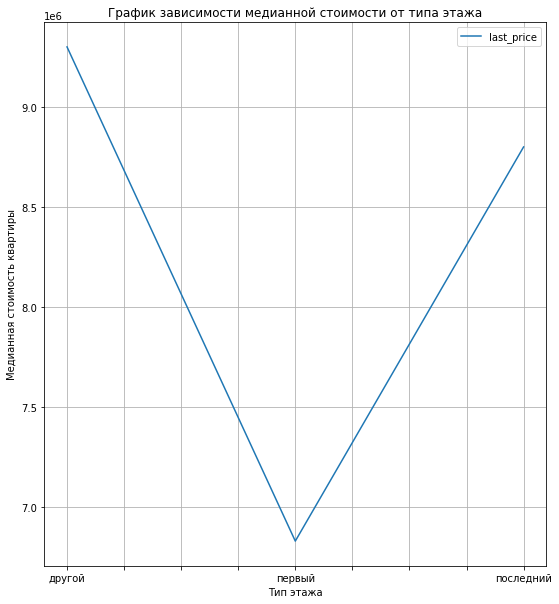

In [39]:
sample_saint_p.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(grid=True, figsize=(9, 10))
plt.title('График зависимости медианной стоимости от типа этажа')
plt.xlabel('Тип этажа')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Зависимость от типа этажа похожа на подобную, построенную на общих данных. В центре также квартиры на первых этажах менее привлекательны и потому дешевле. Квартиры на последних этажах уже не настолько приближены по стоимости к квартирам на первых этажах и имеют не такую большую разницу в стоимости с квартирами на других этажах.

In [40]:
sample_saint_p.pivot_table(index='weekday', values='last_price', aggfunc='median').plot(grid=True, figsize=(7, 10))
plt.title('График зависимости медианной стоимости от дня недели публикации объявления')
plt.xlabel('День недели публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

Зависимость цены от дня недели публикации объявления выглядит иначе. Также пик цены наблюдается во вторник, но наибольший пик по квартирам в центре - в воскресенье. Возможно люди надеются, публикуя объявления в воскресенье, что потенциальные покупатели будут изучать варианты квартир на будущей рабочей неделе и будут готовы рассмотреть вариант по любой стоимости. Любопытно, что минимум цены приходится на субботу, возможно с рассчетом более быстрой продажи, что некоторые покупатели будут готовы на сделку сразу же в воскресенье.

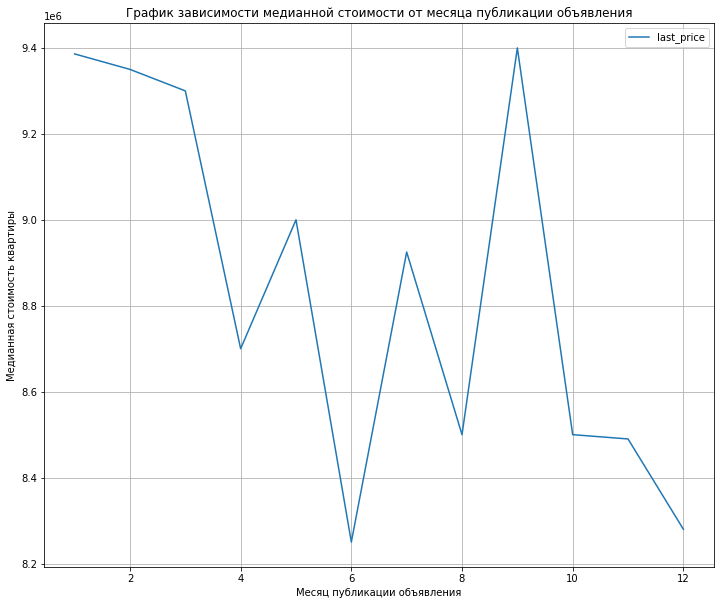

In [41]:
sample_saint_p.pivot_table(index='month', values='last_price', aggfunc='median').plot(grid=True, figsize=(12, 10))
plt.title('График зависимости медианной стоимости от месяца публикации объявления')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

В зависимости стоимости от месяца можно видеть просадку летом, также как и на общих данных. Но в это графике заметен как рост цен осенью, так и резкое падение к декабрю. Скорее всего людям менее охотно заниматься продажей и покупкой квартир перед Новым годом и покупателей меньше, оттого и цены ниже. Зато в январе наступает значительный рост цен, активность растет.

In [42]:
sample_saint_p.pivot_table(index='year', values='last_price', aggfunc='median').plot(grid=True, figsize=(10, 10))
plt.title('График зависимости медианной стоимости от года публикации объявления')
plt.xlabel('Год публикации объявления')
plt.ylabel('Медианная стоимость квартиры')
plt.show()

График зависимости цены квартир в центре от года публикации объявления в целом такой же, как и график, построенный на общих данных. Можно сделать те же самые выводы.

### Вывод

Изучили разные параметры квартир, описали как данные параметры влияют на стоимость жилья, какие из них влияют больше, а какие меньше. Узнали сколько может занимать процесс продажи квартиры и как время продажи зависит от расположения и площади квартиры. Отдельно рассмотрели сегмент квартир в центре Санкт-Петербурга и выяснили, соблюдаются ли те же закономерности в этой области или нет.

### Шаг 5. Общий вывод <a name="Шаг5"></a>

Для работы с данными и их анализа была заполнена большая часть пропусков. Не все пропуски было корректно заполнять какими-либо значениями.

В ходе анализа была выявлена вполне логичная и ожидаемая корреляция стоимости квартиры и ее площади, но найти недорогие варианты с площадью побольше вполне реально. Для поиска квартиры подешевле лучше всего выбрать июль, именно в этот месяц стоимость в течение года минимальна. Это правило работает как для квартир в центре Санкт-Петербурга, так и для близлежащей области. А вот для продажи квартиры по более выгодной цене лучше выбрать январь - тогда средняя цена рынка поднимается.

Не всегда самые дорогие квартиры только в центре, и не все квартиры в центре обязательно дорогие. Стоимость в центре может зависеть от состояния дома, а элитные дорогие квартиры есть и за городом.

Если нет предубеждений по поводу этажа, можно обратить внимание на первые этажи домов - такие квартиры продаются дешевле.

Если нужно продать какое-то нестандартное дорогое жилье с большим количеством комнат, либо квартиры в небольших поселках и деревнях, то нужно быть готовым к длительности процесса - это может занять до полутора лет.